In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow.keras.layers import Conv1D, SpatialDropout1D, BatchNormalization, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import Reshape,Flatten,BatchNormalization,MaxPooling1D,AveragePooling2D,Reshape,Attention, ReLU, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import os
from Config import Config
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, BatchNormalization
from tensorflow.keras.activations import sigmoid

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('always')


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything()

In [3]:
DATA_ROOT = 'TIMNET-dataset'
DATA_PATH = 'RAVDESS'
CLASS_LABELS = Config.RAVDESS_LABELS
k = 10

model_name = 'TIMNet'
feature_name = 'mfcc'

EPOCHS = 300
BATCH = 64

In [4]:
class TAB(tf.keras.Model):
  def __init__(self, i):
    super(TAB, self).__init__()
    
    dilation_rate = 2**(i-1)
    
    self.conv1 = Conv1D(39, kernel_size=1, strides=1, padding='same', dilation_rate=(dilation_rate))
    self.bn1 = BatchNormalization()
    self.spatial_drop1 = SpatialDropout1D(0.1)
    self.conv2 = Conv1D(39, kernel_size=1, strides=1, padding='same', dilation_rate=(dilation_rate))
    self.bn2 = BatchNormalization()
    self.spatial_drop2 = SpatialDropout1D(0.1)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.spatial_drop1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.spatial_drop2(x)
    x = tf.keras.activations.sigmoid(x)
    
    output = inputs * x
    
    return x

In [5]:
class TIMNet(tf.keras.Model):

  def __init__(self, num_classes):
    super(TIMNet, self).__init__()
    
    ## forward TAB
    self.f_tab1 = TAB(1)
    self.f_tab2 = TAB(2)
    self.f_tab3 = TAB(3)
    self.f_tab4 = TAB(4)
    self.f_tab5 = TAB(5)
    
    ## backward TAB
    self.b_tab1 = TAB(1)
    self.b_tab2 = TAB(2)
    self.b_tab3 = TAB(3)
    self.b_tab4 = TAB(4)
    self.b_tab5 = TAB(5)
    
    self.gap = GlobalAveragePooling1D()
    self.fc = Dense(num_classes, activation="softmax")

  def call(self, inputs):
    forward = inputs
    backward = tf.reverse(inputs, axis=[1])
    
    f1 = self.f_tab1(forward)
    b1 = self.b_tab1(backward)
    g1 = self.gap(f1) + self.gap(b1)
    
    f2 = self.f_tab2(f1)
    b2 = self.b_tab2(b1)
    g2 = self.gap(f2) + self.gap(b2)
    
    f3 = self.f_tab2(f2)
    b3 = self.b_tab3(b2)
    g3 = self.gap(f3) + self.gap(b3)
    
    f4 = self.f_tab2(f3)
    b4 = self.b_tab3(b3)
    g4 = self.gap(f4) + self.gap(b4)
    
    f5 = self.f_tab2(f4)
    b5 = self.b_tab3(b4)
    g5 = self.gap(f5) + self.gap(b5)
    
    dynamic_fusion = g1+g2+g3+g4+g5
    output = self.fc(dynamic_fusion)
    
    return output

In [6]:
model = TIMNet(len(CLASS_LABELS))
model.build((64, 182, 39))
model.summary()

Model: "tim_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab (TAB)                   multiple                  3432      
                                                                 
 tab_1 (TAB)                 multiple                  3432      
                                                                 
 tab_2 (TAB)                 multiple                  0 (unused)
                                                                 
 tab_3 (TAB)                 multiple                  0 (unused)
                                                                 
 tab_4 (TAB)                 multiple                  0 (unused)
                                                                 
 tab_5 (TAB)                 multiple                  3432      
                                                                 
 tab_6 (TAB)                 multiple                  3432

In [7]:
@tf.function
def train_step(model, optimizer, x, labels):
    with tf.GradientTape() as tape:
        # 미분 계산
        predictions = model(x, training=True)
        loss = CategoricalCrossentropy()(labels, predictions)
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))     # 신경망 파라미터 업데이트
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy

def test_step(model, x, labels):
    predictions = model(x)
    loss = CategoricalCrossentropy()(labels, predictions)
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100, predictions

In [8]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [9]:
# Smooth label operation
def smooth_labels(labels, factor=0.1):
    """
        smooth the labels
        returned the smoothed labels
    """
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [10]:
from discord_notice import start, end
start()

A Jupyter Widget

A Jupyter Widget

1/300 lr=0.00100 - loss:7.017, acc:0.192, val_loss:7.779, val_acc:8.854
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:3.877, acc:0.219, val_loss:4.826, val_acc:3.646
Best loss:7.779, Best accuracy:8.854, Best F1-score:0.015
3/300 lr=0.00100 - loss:2.694, acc:0.256, val_loss:3.335, val_acc:7.292
Best loss:7.779, Best accuracy:8.854, Best F1-score:0.015
4/300 lr=0.00100 - loss:1.989, acc:0.315, val_loss:2.942, val_acc:5.208
Best loss:7.779, Best accuracy:8.854, Best F1-score:0.015
5/300 lr=0.00100 - loss:1.815, acc:0.312, val_loss:3.354, val_acc:10.938
Best loss:7.779, Best accuracy:8.854, Best F1-score:0.015
6/300 lr=0.00100 - loss:1.784, acc:0.374, val_loss:2.825, val_acc:13.542
Best loss:3.354, Best accuracy:10.938, Best F1-score:0.044
7/300 lr=0.00100 - loss:1.747, acc:0.379, val_loss:2.769, val_acc:12.500
Best loss:2.825, Best accuracy:13.542, Best F1-score:0.058
8/300 lr=0.00100 - loss:1.735, acc:0.397, val_loss:2.620, val_acc:16.667
Best

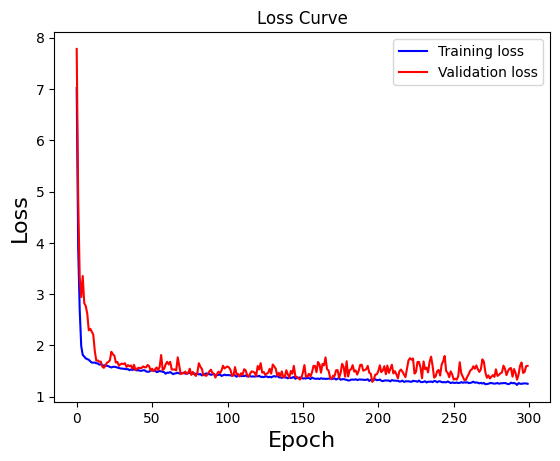

A Jupyter Widget

1/300 lr=0.00100 - loss:9.640, acc:0.074, val_loss:6.794, val_acc:11.458
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:4.847, acc:0.129, val_loss:4.097, val_acc:9.375
Best loss:6.794, Best accuracy:11.458, Best F1-score:0.024
3/300 lr=0.00100 - loss:2.652, acc:0.220, val_loss:3.899, val_acc:17.708
Best loss:6.794, Best accuracy:11.458, Best F1-score:0.024
4/300 lr=0.00100 - loss:1.912, acc:0.297, val_loss:2.417, val_acc:18.750
Best loss:3.899, Best accuracy:17.708, Best F1-score:0.058
5/300 lr=0.00100 - loss:1.799, acc:0.333, val_loss:2.151, val_acc:19.792
Best loss:2.417, Best accuracy:18.750, Best F1-score:0.077
6/300 lr=0.00100 - loss:1.788, acc:0.371, val_loss:1.974, val_acc:21.354
Best loss:2.151, Best accuracy:19.792, Best F1-score:0.100
7/300 lr=0.00100 - loss:1.770, acc:0.347, val_loss:1.825, val_acc:30.208
Best loss:1.974, Best accuracy:21.354, Best F1-score:0.131
8/300 lr=0.00100 - loss:1.760, acc:0.366, val_loss:1.750, val_acc:36.9

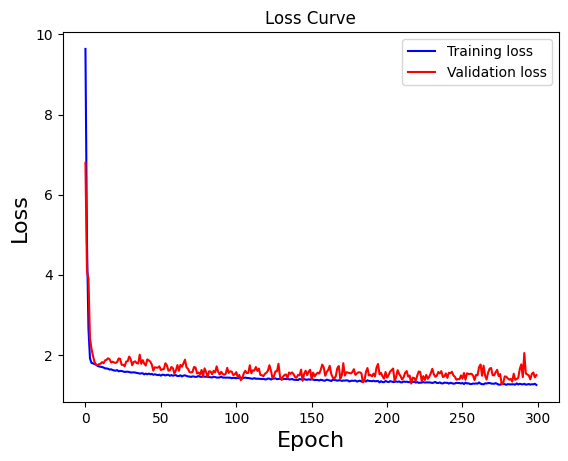

A Jupyter Widget

1/300 lr=0.00100 - loss:7.006, acc:0.147, val_loss:4.285, val_acc:18.750
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:2.694, acc:0.237, val_loss:2.517, val_acc:5.729
Best loss:4.285, Best accuracy:18.750, Best F1-score:0.062
3/300 lr=0.00100 - loss:1.932, acc:0.290, val_loss:2.341, val_acc:23.438
Best loss:4.285, Best accuracy:18.750, Best F1-score:0.062
4/300 lr=0.00100 - loss:1.813, acc:0.331, val_loss:2.206, val_acc:6.771
Best loss:2.341, Best accuracy:23.438, Best F1-score:0.111
5/300 lr=0.00100 - loss:1.777, acc:0.353, val_loss:2.253, val_acc:12.500
Best loss:2.341, Best accuracy:23.438, Best F1-score:0.111
6/300 lr=0.00100 - loss:1.761, acc:0.376, val_loss:2.088, val_acc:20.312
Best loss:2.341, Best accuracy:23.438, Best F1-score:0.111
7/300 lr=0.00100 - loss:1.730, acc:0.376, val_loss:1.944, val_acc:25.000
Best loss:2.341, Best accuracy:23.438, Best F1-score:0.111
8/300 lr=0.00100 - loss:1.723, acc:0.394, val_loss:1.873, val_acc:25.52

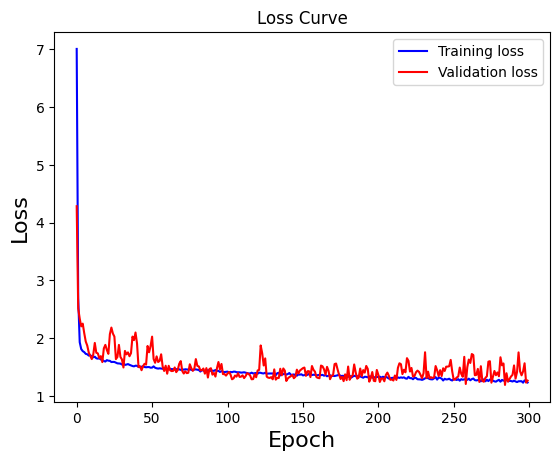

A Jupyter Widget

1/300 lr=0.00100 - loss:8.471, acc:0.135, val_loss:5.468, val_acc:13.542
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:4.032, acc:0.209, val_loss:3.950, val_acc:14.583
Best loss:5.468, Best accuracy:13.542, Best F1-score:0.033
3/300 lr=0.00100 - loss:2.456, acc:0.217, val_loss:2.330, val_acc:17.188
Best loss:3.950, Best accuracy:14.583, Best F1-score:0.038
4/300 lr=0.00100 - loss:1.858, acc:0.307, val_loss:2.299, val_acc:14.583
Best loss:2.330, Best accuracy:17.188, Best F1-score:0.098
5/300 lr=0.00100 - loss:1.796, acc:0.339, val_loss:2.061, val_acc:15.104
Best loss:2.330, Best accuracy:17.188, Best F1-score:0.098
6/300 lr=0.00100 - loss:1.779, acc:0.350, val_loss:1.918, val_acc:17.188
Best loss:2.330, Best accuracy:17.188, Best F1-score:0.098
7/300 lr=0.00100 - loss:1.754, acc:0.368, val_loss:1.762, val_acc:28.646
Best loss:2.330, Best accuracy:17.188, Best F1-score:0.098
8/300 lr=0.00100 - loss:1.730, acc:0.395, val_loss:1.675, val_acc:36.

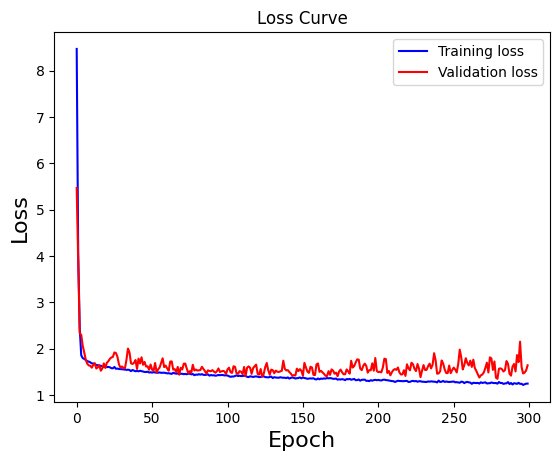

A Jupyter Widget

1/300 lr=0.00100 - loss:3.257, acc:0.178, val_loss:2.208, val_acc:13.542
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:1.965, acc:0.243, val_loss:3.077, val_acc:11.979
Best loss:2.208, Best accuracy:13.542, Best F1-score:0.036
3/300 lr=0.00100 - loss:1.828, acc:0.321, val_loss:2.648, val_acc:11.979
Best loss:2.208, Best accuracy:13.542, Best F1-score:0.036
4/300 lr=0.00100 - loss:1.810, acc:0.333, val_loss:2.618, val_acc:11.979
Best loss:2.208, Best accuracy:13.542, Best F1-score:0.036
5/300 lr=0.00100 - loss:1.772, acc:0.375, val_loss:2.609, val_acc:11.979
Best loss:2.208, Best accuracy:13.542, Best F1-score:0.036
6/300 lr=0.00100 - loss:1.745, acc:0.368, val_loss:2.526, val_acc:12.500
Best loss:2.208, Best accuracy:13.542, Best F1-score:0.036
7/300 lr=0.00100 - loss:1.736, acc:0.391, val_loss:2.244, val_acc:15.104
Best loss:2.208, Best accuracy:13.542, Best F1-score:0.036
8/300 lr=0.00100 - loss:1.710, acc:0.398, val_loss:1.943, val_acc:22.

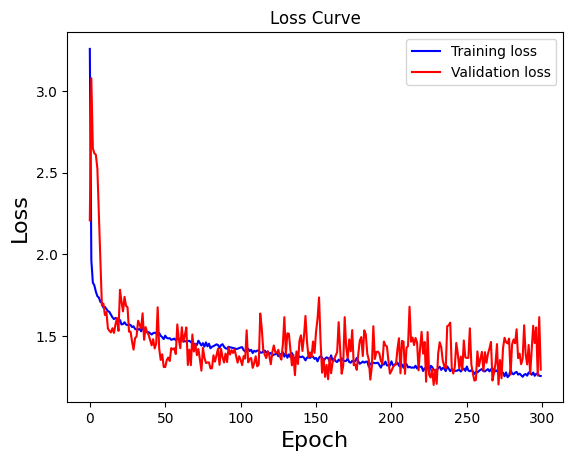

A Jupyter Widget

1/300 lr=0.00100 - loss:5.900, acc:0.159, val_loss:5.604, val_acc:7.292
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:2.990, acc:0.190, val_loss:4.126, val_acc:11.979
Best loss:5.604, Best accuracy:7.292, Best F1-score:0.010
3/300 lr=0.00100 - loss:2.071, acc:0.289, val_loss:3.585, val_acc:10.417
Best loss:4.126, Best accuracy:11.979, Best F1-score:0.052
4/300 lr=0.00100 - loss:1.872, acc:0.336, val_loss:2.827, val_acc:10.417
Best loss:4.126, Best accuracy:11.979, Best F1-score:0.052
5/300 lr=0.00100 - loss:1.811, acc:0.340, val_loss:2.256, val_acc:15.104
Best loss:4.126, Best accuracy:11.979, Best F1-score:0.052
6/300 lr=0.00100 - loss:1.758, acc:0.365, val_loss:2.107, val_acc:17.708
Best loss:2.256, Best accuracy:15.104, Best F1-score:0.068
7/300 lr=0.00100 - loss:1.734, acc:0.386, val_loss:2.086, val_acc:19.271
Best loss:2.107, Best accuracy:17.708, Best F1-score:0.108
8/300 lr=0.00100 - loss:1.713, acc:0.406, val_loss:1.982, val_acc:25.00

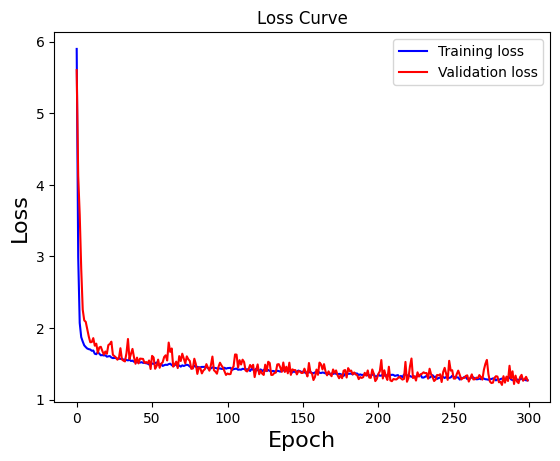

A Jupyter Widget

1/300 lr=0.00100 - loss:6.260, acc:0.132, val_loss:4.293, val_acc:9.375
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:2.837, acc:0.228, val_loss:2.653, val_acc:7.292
Best loss:4.293, Best accuracy:9.375, Best F1-score:0.017
3/300 lr=0.00100 - loss:1.938, acc:0.258, val_loss:2.751, val_acc:7.292
Best loss:4.293, Best accuracy:9.375, Best F1-score:0.017
4/300 lr=0.00100 - loss:1.826, acc:0.316, val_loss:2.696, val_acc:7.812
Best loss:4.293, Best accuracy:9.375, Best F1-score:0.017
5/300 lr=0.00100 - loss:1.774, acc:0.359, val_loss:2.655, val_acc:10.417
Best loss:4.293, Best accuracy:9.375, Best F1-score:0.017
6/300 lr=0.00100 - loss:1.770, acc:0.352, val_loss:2.343, val_acc:14.583
Best loss:2.655, Best accuracy:10.417, Best F1-score:0.062
7/300 lr=0.00100 - loss:1.737, acc:0.397, val_loss:2.054, val_acc:19.271
Best loss:2.343, Best accuracy:14.583, Best F1-score:0.100
8/300 lr=0.00100 - loss:1.726, acc:0.409, val_loss:1.867, val_acc:22.917
Best

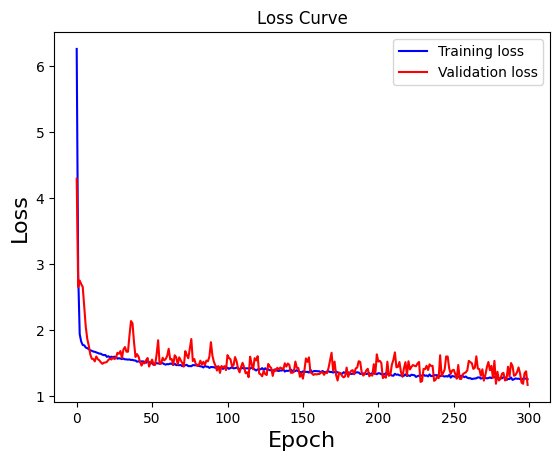

A Jupyter Widget

1/300 lr=0.00100 - loss:6.419, acc:0.167, val_loss:3.355, val_acc:11.979
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:2.472, acc:0.190, val_loss:2.516, val_acc:17.708
Best loss:3.355, Best accuracy:11.979, Best F1-score:0.029
3/300 lr=0.00100 - loss:1.894, acc:0.285, val_loss:2.537, val_acc:9.896
Best loss:2.516, Best accuracy:17.708, Best F1-score:0.065
4/300 lr=0.00100 - loss:1.819, acc:0.334, val_loss:2.442, val_acc:11.979
Best loss:2.516, Best accuracy:17.708, Best F1-score:0.065
5/300 lr=0.00100 - loss:1.779, acc:0.376, val_loss:2.287, val_acc:12.500
Best loss:2.516, Best accuracy:17.708, Best F1-score:0.065
6/300 lr=0.00100 - loss:1.762, acc:0.362, val_loss:2.149, val_acc:17.188
Best loss:2.516, Best accuracy:17.708, Best F1-score:0.065
7/300 lr=0.00100 - loss:1.760, acc:0.368, val_loss:1.869, val_acc:20.833
Best loss:2.516, Best accuracy:17.708, Best F1-score:0.065
8/300 lr=0.00100 - loss:1.738, acc:0.381, val_loss:1.792, val_acc:28.1

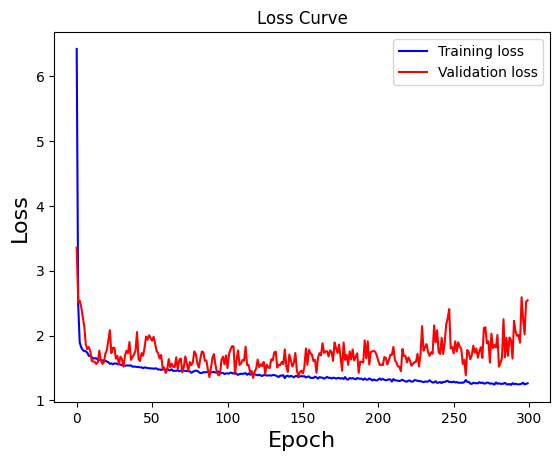

A Jupyter Widget

1/300 lr=0.00100 - loss:4.225, acc:0.161, val_loss:2.802, val_acc:17.188
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:2.192, acc:0.216, val_loss:2.611, val_acc:16.667
Best loss:2.802, Best accuracy:17.188, Best F1-score:0.057
3/300 lr=0.00100 - loss:1.875, acc:0.305, val_loss:2.640, val_acc:16.146
Best loss:2.802, Best accuracy:17.188, Best F1-score:0.057
4/300 lr=0.00100 - loss:1.793, acc:0.339, val_loss:2.738, val_acc:16.146
Best loss:2.802, Best accuracy:17.188, Best F1-score:0.057
5/300 lr=0.00100 - loss:1.774, acc:0.345, val_loss:2.564, val_acc:17.188
Best loss:2.802, Best accuracy:17.188, Best F1-score:0.057
6/300 lr=0.00100 - loss:1.750, acc:0.365, val_loss:2.487, val_acc:17.188
Best loss:2.802, Best accuracy:17.188, Best F1-score:0.057
7/300 lr=0.00100 - loss:1.754, acc:0.374, val_loss:2.116, val_acc:23.958
Best loss:2.802, Best accuracy:17.188, Best F1-score:0.057
8/300 lr=0.00100 - loss:1.730, acc:0.383, val_loss:1.914, val_acc:31.

ResourceExhaustedError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to allocate memory for the batch of component 0 [Op:IteratorGetNext]

In [11]:
import tensorflow_addons as tfa
from keras.models import load_model

emotions_groundtruth_list = np.array([])
predicted_emotions_list = np.array([])

avg_acc = 0.0

kfold = KFold(n_splits=k, shuffle=True, random_state=98)
for i, (train, test) in tqdm(enumerate(kfold.split(x, y)), desc=f'Training {k}-Fold.....'):
    now_time = datetime.now().strftime("%m-%d-%H%M%S")
    
    save_path = f'Models/{DATA_PATH}'
    os.makedirs(save_path, exist_ok=True)
    h5_path = f'{save_path}/{model_name}_{feature_name}_{i}-fold_{now_time}.h5'
    
    x_train, y_train = x[train], y[train]
    y_train = smooth_labels(y[train], 0.1)
    
    x_test, y_test = x[test], y[test]
    
    shape = x_train.shape[1:]
    
    optimizer = Adam(learning_rate=0.001)
    
    model = TIMNet(len(CLASS_LABELS))
    
    best_test_loss = 0x3f3f3f
    best_test_acc = -1
    best_test_f1 = -1
    
    epoch_losses = []
    valid_losses = []
    
    batch_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(46).batch(BATCH)
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
    for epoch in tqdm(range(EPOCHS), desc=f'Fold-{i+1}'):

        train_loss, train_acc = [], []
        for features, labels in batch_train:
            loss, acc = train_step(model, optimizer, features, labels)
            train_loss.append(loss)
            train_acc.append(acc)
            
        test_loss, test_acc, f1s = [], [], []
        for features, labels in batch_test:
            loss, acc, pred = test_step(model, features, labels)
            test_loss.append(loss)
            test_acc.append(acc)
            
            f1_metric = tfa.metrics.F1Score(num_classes=len(CLASS_LABELS), average='weighted')
            f1_metric.update_state(labels, pred)
            f1 = f1_metric.result().numpy()
            f1s.append(f1)
            
        
        epoch_loss = sum(train_loss)/len(train_loss)
        epoch_acc = sum(train_acc)/len(train_acc)
        val_loss = sum(test_loss)/len(test_loss)
        val_acc = sum(test_acc)/len(test_acc)
        f1_score = sum(f1s)/len(f1s)
        
        epoch_losses.append(epoch_loss)
        valid_losses.append(val_loss)
        
        cur_lr = K.eval(optimizer.lr)
        print(f'{epoch+1}/{EPOCHS} lr={cur_lr:.5f} - loss:{epoch_loss:.3f}, acc:{epoch_acc:.3f}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}')
        print(f'Best loss:{best_test_loss:.3f}, Best accuracy:{best_test_acc:.3f}, Best F1-score:{best_test_f1:.3f}')
        
        if best_test_acc < val_acc:
            best_test_acc = val_acc
            best_test_loss = val_loss
            best_test_f1 = f1_score
            model.save_weights(h5_path)
            
            
    model = TIMNet(len(CLASS_LABELS))
    model.build(input_shape=x_train.shape)
    model.load_weights(h5_path)
    best_pred = model(x_test, training=False)
    emotions_groundtruth_list = np.append(emotions_groundtruth_list, np.argmax(y_test, axis=1))
    predicted_emotions_list = np.append(predicted_emotions_list, np.argmax(best_pred, axis=1))
    
    
    print(f'[*] Done - acc:{best_test_acc:.3f}')
    
    plt.title('Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(epoch_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])
    plt.show()
    
    avg_acc += best_test_acc
    

In [ ]:
end()

In [ ]:
avg_acc/k

In [ ]:
import warnings
warnings.filterwarnings('always')

Report = classification_report(emotions_groundtruth_list, predicted_emotions_list)

os.makedirs(f'Results/{DATA_PATH}', exist_ok=True)
report_path = f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_nomalize.txt'

with open(report_path, "w") as f:
    f.write(Report)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

emotion_names = CLASS_LABELS


# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list)
conf_matrix_norm = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list,normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 13}, fmt='g') #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font
plt.savefig(f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_confmatrix.pdf')
plt.show()